# Solution

This notebook aims at discover the solution part by part of what is executed in the main script `main.py`

In [1]:
import os  # nopep8

from IPython import get_ipython  # nopep8

get_ipython().run_line_magic("load_ext", "autoreload")  # nopep8
get_ipython().run_line_magic("autoreload", "2")  # nopep8

In [2]:
# Ease dataset inspections
import pandas as pd
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 10)
pd.set_option("display.expand_frame_repr", False)

/home/manomano/.pyenv/versions/3.7.0/envs/challenge_datafactory_intermarche/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Exploratory Data Analysis


In [3]:
import plotnine as pn
from plotnine import aes, ggplot

from src import preprocessing as prep

coef = 1.5
pn.options.figure_size = (6.4 * coef, 4.8 * coef)

sales = prep.read_sales()

agg_func = {"qte": "sum", "id_artc": "nunique"}

sales_agg = sales.groupby("date").agg(agg_func).reset_index()
sales_agg = sales_agg.rename(columns={"id_artc": "active_products"})
sales_agg[["qte_7", "active_products_7"]] = (
    sales_agg[["qte", "active_products"]].rolling(7).mean()
)



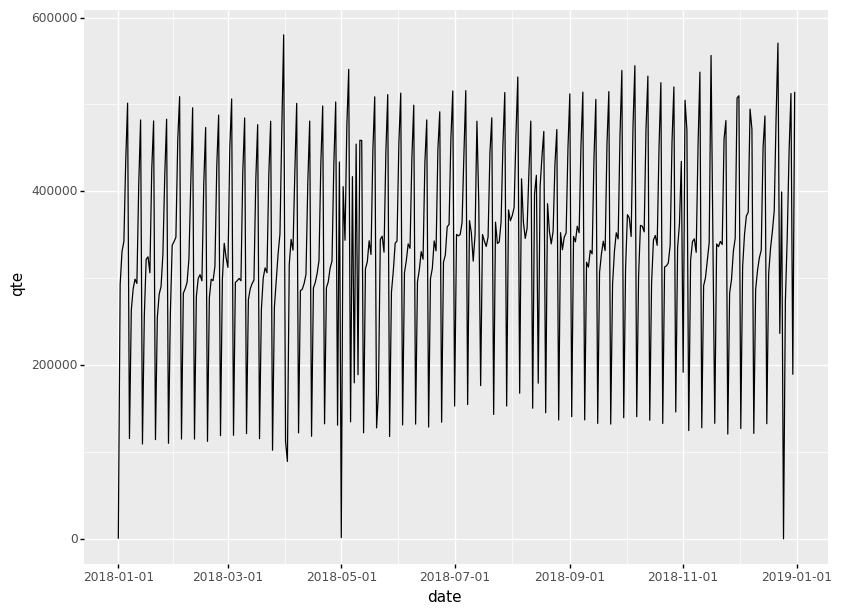

<ggplot: (-9223363295648372143)>

In [4]:
(ggplot(sales_agg, aes("date", "qte")) + pn.geoms.geom_line())

/home/manomano/.pyenv/versions/3.7.0/envs/challenge_datafactory_intermarche/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


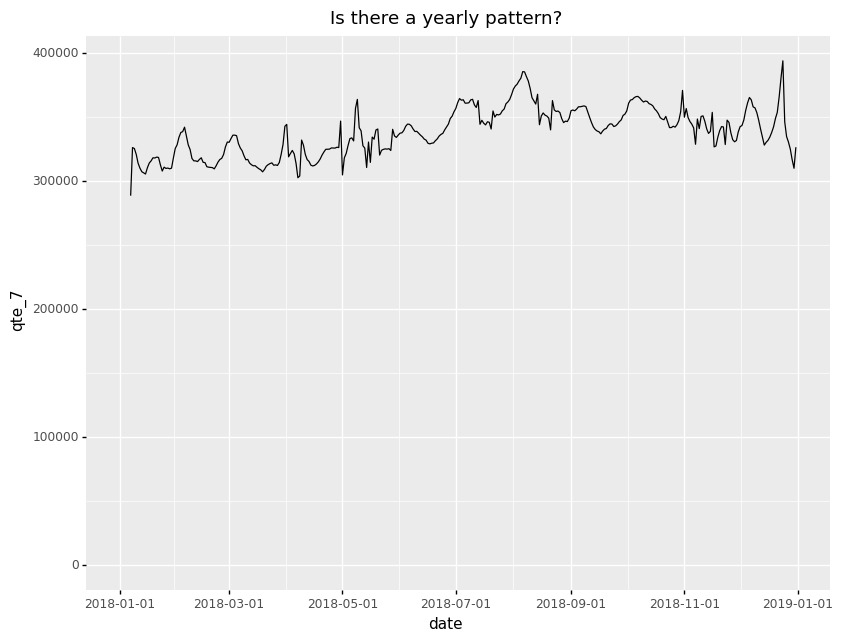

<ggplot: (8741206278383)>

In [5]:
(
    ggplot(sales_agg, aes("date", "qte_7"))
    + pn.geoms.geom_line()
    + pn.scales.scale_y_continuous(limits=(0, pd.NA))
    + pn.labs(title="Is there a yearly pattern?")
)

/home/manomano/.pyenv/versions/3.7.0/envs/challenge_datafactory_intermarche/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


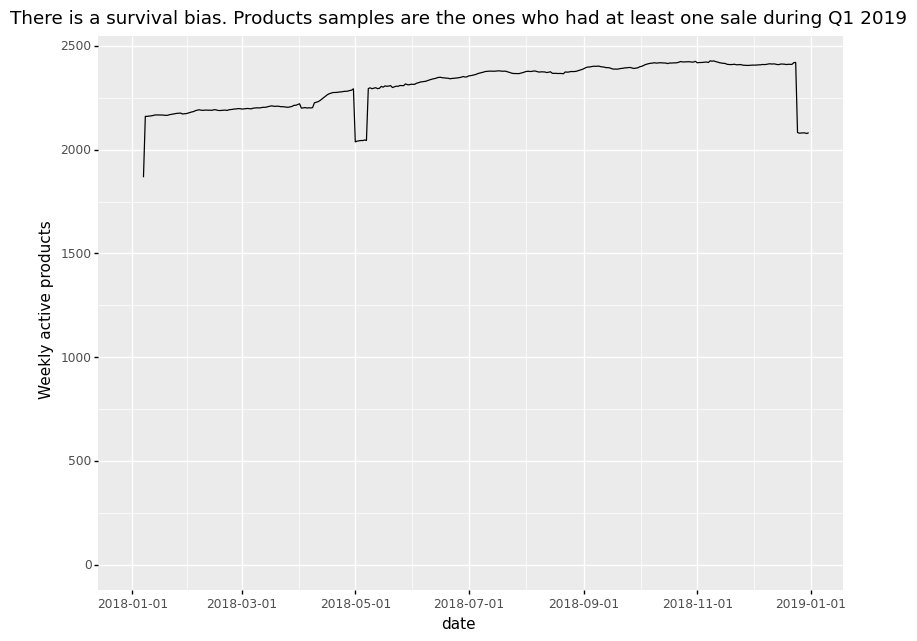

<ggplot: (-9223363295649557767)>

In [6]:
(
    ggplot(sales_agg, aes("date", "active_products_7"))
    + pn.geoms.geom_line()
    + pn.scales.scale_y_continuous(limits=(0, pd.NA))
    + pn.labs(
        title="There is a survival bias. Products samples are the ones who had at least one sale during Q1 2019",  # noqa
        y="Weekly active products",
    )
)

![meme](https://i.kym-cdn.com/entries/icons/original/000/028/021/work.jpg)


In [7]:
from src import create_datasets, train_predict

# Create datasets
To speed up things we are going to work in the "demo" env where we sample data by a factor of 100

In [8]:
print(create_datasets.create_datasets.__doc__)

Create learning (train/validation) and production dataset. To do so various
    featuresets are created then merged altogether.


In [9]:
import pandas as pd

from src import constants
from src import feature_engineering as fe
from src import path
from src import preprocessing as prep


In [10]:
print(f"CURRENT_ENVIRONMENT: {constants.CURRENT_ENVIRONMENT}")

CURRENT_ENVIRONMENT: demo


In [11]:

sales = prep.read_sales()
sales

id_pdv  id_artc       date  qte  qte_lop1p
0            102      398 2018-05-14    3   1.386294
1            102     2273 2018-05-14    1   0.693147
2              5     1345 2018-05-14    1   0.693147
3             87      290 2018-05-14    9   2.302585
4            118        7 2018-05-14   15   2.772589
...          ...      ...        ...  ...        ...
32793013     142     1100 2018-11-16    1   0.693147
32793014      50      474 2018-11-16    1   0.693147
32793015      35     1390 2018-11-16    1   0.693147
32793016      59     1783 2018-11-16    1   0.693147
32793017      52      646 2018-11-16    1   0.693147

[32793018 rows x 5 columns]

In [12]:
prix = prep.read_prix()
prix

Sample by a factor of 100


id_pdv  id_artc    prix date_destination
598481       34     1466   3.495       2018-01-01
508578       20      980  18.995       2018-01-01
508885       29     1671   1.495       2018-01-01
509241       29     2071   1.495       2018-01-01
509827      117     2083   2.495       2018-01-01
...         ...      ...     ...              ...
691142      136      664   0.495       2019-01-01
865779      145     1855   1.495       2019-01-01
1002925     117     2283   6.495       2019-01-01
140427       87      913   3.495       2019-01-01
799051      137     1863   1.495       2019-01-01

[11744 rows x 4 columns]

In [13]:
nomenclature = prep.read_nomenclature()
nomenclature

id_artc             lb_vent_rayn                    lb_vent_faml                        lb_vent_sous_faml
0         905              CREMERIE LS                     ULTRA FRAIS                  ULTRA FRAIS - SS-FAML 2
1         477                 LIQUIDES     BOISSONS GAZEUSES ET PLATES  BOISSONS GAZEUSES ET PLATES - SS-FAML 6
2         863                 LIQUIDES                BIERES ET CIDRES             BIERES ET CIDRES - SS-FAML 2
3        1741          EPICERIE SUCREE                CAFES / CHICOREE             CAFES / CHICOREE - SS-FAML 2
4         983              CREMERIE LS                      FROMAGE LS                   FROMAGE LS - SS-FAML 2
...       ...                      ...                             ...                                      ...
2495      370              BAZAR LEGER  ACCESSOIRE / GADGET DE CUISINE           ACCESSOIRE / GADGET DE CUISINE
2496      308              CREMERIE LS                      FROMAGE LS                   FROMAGE LS - SS-FAML 1
2497     2467                   D.P.H.   ACCESSOIRES COIFFANT/TOILETTE            ACCESSOIRES COIFFANT/TOILETTE
2498      540  CHARCUTERIE TRAITEUR LS                     TRAITEUR LS                  TRAITEUR LS - SS-FAML 7
2499      631          EPICERIE SUCREE                     BISCUITERIE                  BISCUITERIE - SS-FAML 1

[2500 rows x 4 columns]

In [14]:
nomenclature_sales = pd.merge(sales, nomenclature)
nomenclature_sales


id_pdv  id_artc       date  qte  qte_lop1p lb_vent_rayn                    lb_vent_faml               lb_vent_sous_faml
0            102      398 2018-05-14    3   1.386294  CREMERIE LS                      FROMAGE LS          FROMAGE LS - SS-FAML 3
1             18      398 2018-11-22    2   1.098612  CREMERIE LS                      FROMAGE LS          FROMAGE LS - SS-FAML 3
2            141      398 2018-05-29    1   0.693147  CREMERIE LS                      FROMAGE LS          FROMAGE LS - SS-FAML 3
3              9      398 2018-05-29    1   0.693147  CREMERIE LS                      FROMAGE LS          FROMAGE LS - SS-FAML 3
4             32      398 2018-02-09    3   1.386294  CREMERIE LS                      FROMAGE LS          FROMAGE LS - SS-FAML 3
...          ...      ...        ...  ...        ...          ...                             ...                             ...
32793013      37     2500 2018-08-18    1   0.693147  BAZAR LEGER  ACCESSOIRE / GADGET DE CUISINE  ACCESSOIRE / GADGET DE CUISINE
32793014      59     2500 2018-12-08    1   0.693147  BAZAR LEGER  ACCESSOIRE / GADGET DE CUISINE  ACCESSOIRE / GADGET DE CUISINE
32793015      38     2500 2018-03-10    1   0.693147  BAZAR LEGER  ACCESSOIRE / GADGET DE CUISINE  ACCESSOIRE / GADGET DE CUISINE
32793016     124     2500 2018-01-27    1   0.693147  BAZAR LEGER  ACCESSOIRE / GADGET DE CUISINE  ACCESSOIRE / GADGET DE CUISINE
32793017      57     2500 2018-10-13    1   0.693147  BAZAR LEGER  ACCESSOIRE / GADGET DE CUISINE  ACCESSOIRE / GADGET DE CUISINE

[32793018 rows x 8 columns]

In [15]:
print(prep.get_holidays_fr.__doc__)
holidays_fr = prep.get_holidays_fr()
holidays_fr[holidays_fr['is_holiday'].notnull()]

For a given date_destination, return distance to next/previous holiday cliped
    between [-1, 1]

    Returns:
        pd.DataFrame: holidays_fr
    


date_destination  is_holiday
0         2018-01-01         0.0
1         2018-01-02         1.0
90        2018-04-01        -1.0
91        2018-04-02         0.0
92        2018-04-03         1.0
..               ...         ...
358       2018-12-25         0.0
359       2018-12-26         1.0
364       2018-12-31        -1.0
365       2019-01-01         0.0
366       2019-01-02         1.0

[34 rows x 2 columns]

In [16]:
print(fe.get_group_dow_trend.__doc__)
category_dow_trend = []
cols_group_dow = (
    fe.cols_category + [["id_pdv"]] + [col + ["id_pdv"] for col in fe.cols_category]
)

for cols_group in cols_group_dow:
    print(cols_group)
    tmp_category_dow_trend = fe.get_group_dow_trend(
        nomenclature_sales, cols_group=cols_group
    )
    category_dow_trend.append(tmp_category_dow_trend)
['id_pdv']
# Display sample result of first group

category_dow_trend[0].sample(10)


    Compute day of the week (dow / weekly) sales  at granularity cols_group
    Final dataset granularity is cols_group + ['date_destination_dow'].

    Note: we are cheating a little bit here should be done out-of-fold, but we assume
    overfitting is small.

    Args:
        nomenclature_sales (pd.DataFrame): [description]
        cols_group (list): granularity of the target encoding

    Returns:
        pd.DataFrame: [description]
    
['lb_vent_rayn']
['lb_vent_faml']
['id_pdv']
['lb_vent_rayn', 'id_pdv']
['lb_vent_faml', 'id_pdv']


lb_vent_rayn  date_destination_dow  LB_VENT_RAYN_&_DATE_DOW_qte  LB_VENT_RAYN_&_DATE_DOW_qte_pct
52    EPICERIE SUCREE                     3                      1599471                         0.143366
95        VOLAILLE LS                     4                        52319                         0.178204
76  PAIN PAT LS INDUS                     6                       311215                         0.060259
81        SAURISSERIE                     4                       158099                         0.200188
87           SURGELES                     3                       347567                         0.136061
19       BOUCHERIE LS                     5                       201326                         0.226055
33        CREMERIE LS                     5                      7287189                         0.210843
56  FRUITS ET LEGUMES                     0                       251566                         0.140985
16       BOUCHERIE LS                     2                       120286                         0.135061
72  PAIN PAT LS INDUS                     2                       735978                         0.142504

In [17]:
print(fe.get_yearly_trend_week.__doc__)
cols_group_yearly_trend_week = [
    ["lb_vent_rayn"],
    # ["id_pdv"], => Should have added this but forgot
]

l_yearly_trend_week = []
for cols_group in cols_group_yearly_trend_week:
    print(cols_group)
    l_yearly_trend_week.append(
        fe.get_yearly_trend_week(nomenclature_sales, cols_group)
    )

l_yearly_trend_week[0].sample(10)


Yearly saisonnality for weeks at cols_group granularity. To unbias the number of
    products active products, we multiply this seasonality by the inverse of the
    variation of active products.

    Note : This feature is leaked but consider this as our best estimate for yearly
    saisonnality. Should be done out-of-fold in prod.

    Args:
        nomenclature_sales (pd.DataFrame): [description]
        cols_group (list): [description]

    Returns:
        pd.DataFrame: [description]
    
['lb_vent_rayn']


lb_vent_rayn  date_origin_week  date_destination_week  LB_VENT_RAYN_yearly_trend_week
7994              BOUCHERIE LS                44                     44                        1.000000
38839              VOLAILLE LS                43                     43                        1.000000
12764              CREMERIE LS                28                     44                        1.051913
5252               BAZAR LEGER                46                      5                        1.420000
28366        PAIN PAT LS INDUS                 5                     11                        0.944000
32211              SAURISSERIE                24                     40                        0.840000
20528          EPICERIE SUCREE                16                     17                        1.061538
38307              VOLAILLE LS                33                     41                        0.918750
10766  CHARCUTERIE TRAITEUR LS                44                      7                        1.021082
12706              CREMERIE LS                27                     39                        1.134863

In [18]:
print(prep.sample_dataset.__doc__)
sales = prep.sample_dataset(sales)
sales


Sample dataset at ["id_artc", "id_pdv"] granularities to speed up developement.
    Sampling factor depends on the CURRENT_ENVIRONMENT.
    Do it after the feature engineering at high granularities (fast to compute) and
    before the ones at low granularities (slow to compute).
    
Sample by a factor of 100


id_pdv  id_artc       date  qte  qte_lop1p
0            102      398 2018-05-14    3   1.386294
40           122      178 2018-05-14   12   2.564949
41           149       51 2018-05-14   27   3.332205
111          139     1361 2018-05-14    2   1.098612
428            4     1796 2018-05-14    1   0.693147
...          ...      ...        ...  ...        ...
32792325     148      452 2018-01-13    4   1.609438
32792401      14     1286 2018-01-13    1   0.693147
32792605      90       10 2018-11-16   41   3.737670
32792617     126      474 2018-11-16    8   2.197225
32792653      60      740 2018-11-16    6   1.945910

[326084 rows x 5 columns]

In [19]:
print(prep.complete_sales.__doc__)
sales = prep.complete_sales(sales)
sales

Fill implicit 0 values by generating one line for each day*product between start
    and end date and sales.

    "2018-05-01" is a buggy dates. Fill it with NA to avoid considering NA as 0 inside
    feature engineering.

    Args:
        sales (pd.DataFrame): sales data with only non negative sales

    Returns:
        pd.DataFrame: sales data with implicit 0 values
    


date  id_pdv  id_artc   qte  qte_lop1p
1027   2018-01-01      25      175   3.0   1.386294
2721   2018-01-02     102      398   3.0   1.386294
2722   2018-01-02     122      178  16.0   2.833213
2723   2018-01-02     149       51  21.0   3.091042
2725   2018-01-02       4     1796   2.0   1.098612
...           ...     ...      ...   ...        ...
993160 2018-12-31       4      296   0.0   0.000000
993161 2018-12-31      32     1868   0.0   0.000000
993162 2018-12-31     110      790   0.0   0.000000
993163 2018-12-31      24      576   0.0   0.000000
993164 2018-12-31     137      863   0.0   0.000000

[875944 rows x 5 columns]

In [20]:
print(fe.fe_products_first_sale.__doc__)
products_first_sale = fe.fe_products_first_sale(sales)
products_first_sale




    Date of first sale for ["id_pdv", "id_artc"]
    


id_pdv  id_artc ID_PDV_&_ID_ARTC_date_min
0          1       99                2018-01-31
1          1      199                2018-01-02
2          1      299                2018-01-13
3          1      399                2018-01-02
4          1      499                2018-01-03
...      ...      ...                       ...
2716     149     2051                2018-01-02
2717     149     2151                2018-01-17
2718     149     2251                2018-01-03
2719     149     2351                2018-01-06
2720     149     2451                2018-11-24

[2721 rows x 3 columns]

In [21]:
print(fe.get_fe_prix.__doc__)
fe_prix = fe.get_fe_prix(prix)
fe_prix.sample(10)


Average price by quarter for ["id_pdv", "id_artc"]

    Args:
        prix (pd.DataFrame): [description]

    Returns:
        pd.DataFrame: [description]
    


id_pdv  id_artc date_destination  ID_PDV_&_ID_ARTC_prix_mean_1
1115421      16     1584       2018-10-02                         5.495
709089       92     1008       2018-07-02                         2.495
572212       56     2344       2018-10-02                         3.495
519745       79     1921       2018-10-02                         1.495
601178       65      235       2019-01-02                         1.495
989052      108     1892       2018-10-02                         3.495
190320       52     1448       2018-01-02                         3.495
53567        93     1107       2018-04-02                         1.495
817773      126      874       2018-10-02                         1.495
310183      146     1054       2018-01-02                         2.495

In [22]:
print(fe._get_fe_sales.__doc__)
fe_sales = fe.get_fe_sales(sales, is_parallel=constants.IS_PARALLEL)
fe_sales.sample(10)


Returns various rolling FE (mean, median, quantile, std) of cols
    ["qte", "qte_lop1p"] at ["id_pdv", "id_artc"] granularity

    Args:
        sales (pd.DataFrame): [description]

    Returns:
        pd.DataFrame: [description]
    
get_fe_sales
Elapsed time: 21.8 seconds


date_origin  id_pdv  id_artc  ID_PDV_&_ID_ARTC_qte_mean_1  ID_PDV_&_ID_ARTC_qte_lop1p_mean_1  ID_PDV_&_ID_ARTC_qte_median_1  ID_PDV_&_ID_ARTC_qte_lop1p_median_1  ID_PDV_&_ID_ARTC_qte_std_1  ID_PDV_&_ID_ARTC_qte_lop1p_std_1  ID_PDV_&_ID_ARTC_qte_quantile_0.80_1  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_1  ID_PDV_&_ID_ARTC_qte_mean_3  ID_PDV_&_ID_ARTC_qte_lop1p_mean_3  ID_PDV_&_ID_ARTC_qte_median_3  ID_PDV_&_ID_ARTC_qte_lop1p_median_3  ID_PDV_&_ID_ARTC_qte_std_3  ID_PDV_&_ID_ARTC_qte_lop1p_std_3  ID_PDV_&_ID_ARTC_qte_quantile_0.80_3  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_3  ID_PDV_&_ID_ARTC_qte_mean_7  ID_PDV_&_ID_ARTC_qte_lop1p_mean_7  ID_PDV_&_ID_ARTC_qte_median_7  ID_PDV_&_ID_ARTC_qte_lop1p_median_7  ID_PDV_&_ID_ARTC_qte_std_7  ID_PDV_&_ID_ARTC_qte_lop1p_std_7  ID_PDV_&_ID_ARTC_qte_quantile_0.80_7  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_7  ID_PDV_&_ID_ARTC_qte_mean_14  ID_PDV_&_ID_ARTC_qte_lop1p_mean_14  ID_PDV_&_ID_ARTC_qte_median_14  ID_PDV_&_ID_ARTC_qte_lop1p_median_14  ID_PDV_&_ID_ARTC_qte_std_14  ID_PDV_&_ID_ARTC_qte_lop1p_std_14  ID_PDV_&_ID_ARTC_qte_quantile_0.80_14  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_14  ID_PDV_&_ID_ARTC_qte_mean_28  ID_PDV_&_ID_ARTC_qte_lop1p_mean_28  ID_PDV_&_ID_ARTC_qte_median_28  ID_PDV_&_ID_ARTC_qte_lop1p_median_28  ID_PDV_&_ID_ARTC_qte_std_28  ID_PDV_&_ID_ARTC_qte_lop1p_std_28  ID_PDV_&_ID_ARTC_qte_quantile_0.80_28  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_28  ID_PDV_&_ID_ARTC_qte_mean_56  ID_PDV_&_ID_ARTC_qte_lop1p_mean_56  ID_PDV_&_ID_ARTC_qte_median_56  ID_PDV_&_ID_ARTC_qte_lop1p_median_56  ID_PDV_&_ID_ARTC_qte_std_56  ID_PDV_&_ID_ARTC_qte_lop1p_std_56  ID_PDV_&_ID_ARTC_qte_quantile_0.80_56  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_56  ID_PDV_&_ID_ARTC_qte_mean_112  ID_PDV_&_ID_ARTC_qte_lop1p_mean_112  ID_PDV_&_ID_ARTC_qte_median_112  ID_PDV_&_ID_ARTC_qte_lop1p_median_112  ID_PDV_&_ID_ARTC_qte_std_112  ID_PDV_&_ID_ARTC_qte_lop1p_std_112  ID_PDV_&_ID_ARTC_qte_quantile_0.80_112  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_112  ID_PDV_&_ID_ARTC_qte_mean_224  ID_PDV_&_ID_ARTC_qte_lop1p_mean_224  ID_PDV_&_ID_ARTC_qte_median_224  ID_PDV_&_ID_ARTC_qte_lop1p_median_224  ID_PDV_&_ID_ARTC_qte_std_224  ID_PDV_&_ID_ARTC_qte_lop1p_std_224  ID_PDV_&_ID_ARTC_qte_quantile_0.80_224  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_224  ID_PDV_&_ID_ARTC_qte_mean_448  ID_PDV_&_ID_ARTC_qte_lop1p_mean_448  ID_PDV_&_ID_ARTC_qte_median_448  ID_PDV_&_ID_ARTC_qte_lop1p_median_448  ID_PDV_&_ID_ARTC_qte_std_448  ID_PDV_&_ID_ARTC_qte_lop1p_std_448  ID_PDV_&_ID_ARTC_qte_quantile_0.80_448  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_448
813440  2018-12-08     146     2354                          0.0                           0.000000                            0.0                             0.000000                         NaN                               NaN                                   0.0                                    0.000000                     0.000000                           0.000000                            0.0                             0.000000                    0.000000                      0.000000e+00                                   0.0                                    0.000000                     0.000000                           0.000000                            0.0                             0.000000                8.603189e-09                      6.083374e-09                                   0.0                                    0.000000                      0.000000                            0.000000                             0.0                              0.000000                 5.844716e-09                       4.132839e-09                                    0.0                                     0.000000                      0.035714                            0.024755                             0.0                              0.000000                     0.188982                           0.130993                                    0.0                             

In [23]:
print(fe._get_fe_sales_dow.__doc__)
fe_sales_dow = fe.get_fe_sales_dow(sales, is_parallel=constants.IS_PARALLEL)
fe_sales_dow.sample(10)

Returns rolling mean and median of cols ["qte", "qte_lop1p"] at
    ["id_pdv", "id_artc", "date_dow"] granularity

    Args:
        sales (pd.DataFrame): [description]

    Returns:
        pd.DataFrame: [description]
    
get_fe_sales_dow
Elapsed time: 45.9 seconds


date_origin  date_destination_dow  id_pdv  id_artc  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_1  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_1  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_1  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_1  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_2  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_2  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_2  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_2  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_4  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_4  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_4  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_4  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_8  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_8  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_8  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_8  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_16  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_16  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_16  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_16  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_32  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_32  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_32  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_32  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_64  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_64  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_64  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_64
205842  2018-04-13                     4      86      414                                     0.0                                      0.000000                                       0.0                                        0.000000                                     0.0                                  0.000000e+00                                       0.0                                        0.000000                                    0.00                                  0.000000e+00                                       0.0                                        0.000000                                   0.000                                      0.000000                                       0.0                                        0.000000                                 0.692308                                       0.314950                                        0.0                                         0.000000                                 0.692308                                       0.314950                                        0.0                                         0.000000                                 0.692308                                       0.314950                                        0.0                                         0.000000
289653  2018-05-19                     5      86      514                                     0.0                                      0.000000                                       0.0                                        0.000000                                     0.0                                  0.000000e+00                                       0.0                                        0.000000                                    1.25                                  5.756463e-01                                       0.5                                        0.346574                                   0.625                                      0.287823                                       0.0                                        0.000000                                 0.562500                                       0.299218                                        0.0                                         0.000000                                 1.058824                                       0.417063                                        0.0                                         0.000000                                 1.058824                                       0.417063                                        0.0                                         0.000000
371656  2018-06-22                     4      50      250                                     6.0    

In [24]:
print(fe.fe_evaluated.__doc__)
evaluated = fe.fe_evaluated(fe_sales)
evaluated.sample(10)


    Detect target rows which are not evaluated during the challenge.
    See rules of the challenge:
    'L'évaluation s'applique uniquement aux prédictions attendues, c.-à-d. pour
    lesquelles au moins une vente réelle (du produit par le point de vente en
    question) a bien été constatée le jour même ou dans les six jours précédents.
    Dans le cas contraire, la prédiction ne sera pas pénalisée et n'entrera pas dans
    le calcul du score.'
    


date_destination  id_pdv  id_artc  evaluated
460944       2018-07-27     136     2164       True
240688       2018-04-28      97     1803      False
832402       2018-12-15     146     2354      False
782854       2018-11-27      71      929      False
568295       2018-09-07     116     1184       True
277062       2018-05-14     136      464       True
425416       2018-07-13      49      551       True
462670       2018-07-28      21       79       True
425902       2018-07-13      92      308      False
728959       2018-11-07     119      681       True

In [25]:
print(prep.generate_main_learning.__doc__)
main_learning = prep.generate_main_learning(sales)
main_learning.sample(10)


Generate the main dataset. Main dataset is the dataset at the granularity of our
    predictions ['id_pdv', 'id_artc', 'date_origin', 'horizon', 'date_destination']
    and their associated target/sales.

    * We subjectively decide december is not a representative month and remove it
    (multiple stores exceptionnaly opens on sunday).

    * "2018-05-01" is a buggy date therefore is removed.
    This two magic tricks gave a huge boost ~0.01

    Also performs sample with constants.LEARNING_SIZE_MAX

    Args:
        sales (pd.DataFrame): sales data

    Returns:
        pd.DataFrame: main dataset for learning set
    
generate_main_learning
Elapsed time: 5.4 seconds


date_origin  id_pdv  id_artc  horizon date_destination  qte  qte_lop1p
6643330  2018-04-05      31      869      103       2018-07-17  1.0   0.693147
3134740  2018-04-30     145      755      103       2018-08-11  0.0   0.000000
5427097  2018-03-29       2     1798       78       2018-06-15  0.0   0.000000
422231   2018-06-26      64     2036       83       2018-09-17  0.0   0.000000
1719411  2018-08-26     139     1261       47       2018-10-12  2.0   1.098612
4343472  2018-04-11      16     1384       56       2018-06-06  0.0   0.000000
5506764  2018-08-02     130     1470       48       2018-09-19  0.0   0.000000
2366969  2018-04-24      22     1378       74       2018-07-07  1.0   0.693147
6715013  2018-02-28      95     2305       53       2018-04-22  0.0   0.000000
3917877  2018-04-24      15     1785       85       2018-07-18  0.0   0.000000

In [26]:
# list of dataframe we want to perform a left join
left_join = [
    fe_sales,
    products_first_sale,
    nomenclature,
    holidays_fr,
] + category_dow_trend

backward_join = [fe_sales_dow]
backward_join_destination = [prix, fe_prix, evaluated]

print(fe.get_learning.__doc__)
learning = fe.get_learning(
    main_learning,
    left_join,
    backward_join,
    backward_join_destination,
)
print(learning.shape)

Merge our different datasets altogether

    Args:
        main_learning (pd.DataFrame): main dataset
        left_join ([type]): list of featuresets to left-join
        backward_join ([type]): list of featuresets to backward-join (on date_origin)
        backward_join_destination ([type]): list of featuresets to backward-join on the
        date_destination
    Returns:
        pd.DataFrame: learning/prod set
    
get_learning
Elapsed time: 98.5 seconds
(5000000, 129)


In [27]:
print(fe.fe_learning.__doc__)
learning = fe.fe_learning(learning)
learning.to_parquet(path.path_learning)
learning

Contextual feature engineering like price trend, age of the products
    https://medium.com/manomano-tech/a-framework-for-feature-engineering-and-machine-learning-pipelines-ddb53867a420 :) # noqa
    


date_origin  id_pdv  id_artc  horizon date_destination   qte  qte_lop1p  date_destination_dow  date_origin_week  date_destination_week  date_destination_dayofmonth  ID_PDV_&_ID_ARTC_qte_mean_1  ID_PDV_&_ID_ARTC_qte_lop1p_mean_1  ID_PDV_&_ID_ARTC_qte_median_1  ID_PDV_&_ID_ARTC_qte_lop1p_median_1  ID_PDV_&_ID_ARTC_qte_std_1  ID_PDV_&_ID_ARTC_qte_lop1p_std_1  ID_PDV_&_ID_ARTC_qte_quantile_0.80_1  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_1  ID_PDV_&_ID_ARTC_qte_mean_3  ID_PDV_&_ID_ARTC_qte_lop1p_mean_3  ID_PDV_&_ID_ARTC_qte_median_3  ID_PDV_&_ID_ARTC_qte_lop1p_median_3  ID_PDV_&_ID_ARTC_qte_std_3  ID_PDV_&_ID_ARTC_qte_lop1p_std_3  ID_PDV_&_ID_ARTC_qte_quantile_0.80_3  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_3  ID_PDV_&_ID_ARTC_qte_mean_7  ID_PDV_&_ID_ARTC_qte_lop1p_mean_7  ID_PDV_&_ID_ARTC_qte_median_7  ID_PDV_&_ID_ARTC_qte_lop1p_median_7  ID_PDV_&_ID_ARTC_qte_std_7  ID_PDV_&_ID_ARTC_qte_lop1p_std_7  ID_PDV_&_ID_ARTC_qte_quantile_0.80_7  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_7  ID_PDV_&_ID_ARTC_qte_mean_14  ID_PDV_&_ID_ARTC_qte_lop1p_mean_14  ID_PDV_&_ID_ARTC_qte_median_14  ID_PDV_&_ID_ARTC_qte_lop1p_median_14  ID_PDV_&_ID_ARTC_qte_std_14  ID_PDV_&_ID_ARTC_qte_lop1p_std_14  ID_PDV_&_ID_ARTC_qte_quantile_0.80_14  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_14  ID_PDV_&_ID_ARTC_qte_mean_28  ID_PDV_&_ID_ARTC_qte_lop1p_mean_28  ID_PDV_&_ID_ARTC_qte_median_28  ID_PDV_&_ID_ARTC_qte_lop1p_median_28  ID_PDV_&_ID_ARTC_qte_std_28  ID_PDV_&_ID_ARTC_qte_lop1p_std_28  ID_PDV_&_ID_ARTC_qte_quantile_0.80_28  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_28  ID_PDV_&_ID_ARTC_qte_mean_56  ID_PDV_&_ID_ARTC_qte_lop1p_mean_56  ID_PDV_&_ID_ARTC_qte_median_56  ID_PDV_&_ID_ARTC_qte_lop1p_median_56  ID_PDV_&_ID_ARTC_qte_std_56  ID_PDV_&_ID_ARTC_qte_lop1p_std_56  ID_PDV_&_ID_ARTC_qte_quantile_0.80_56  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_56  ID_PDV_&_ID_ARTC_qte_mean_112  ID_PDV_&_ID_ARTC_qte_lop1p_mean_112  ID_PDV_&_ID_ARTC_qte_median_112  ID_PDV_&_ID_ARTC_qte_lop1p_median_112  ID_PDV_&_ID_ARTC_qte_std_112  ID_PDV_&_ID_ARTC_qte_lop1p_std_112  ID_PDV_&_ID_ARTC_qte_quantile_0.80_112  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_112  ID_PDV_&_ID_ARTC_qte_mean_224  ID_PDV_&_ID_ARTC_qte_lop1p_mean_224  ID_PDV_&_ID_ARTC_qte_median_224  ID_PDV_&_ID_ARTC_qte_lop1p_median_224  ID_PDV_&_ID_ARTC_qte_std_224  ID_PDV_&_ID_ARTC_qte_lop1p_std_224  ID_PDV_&_ID_ARTC_qte_quantile_0.80_224  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_224  ID_PDV_&_ID_ARTC_qte_mean_448  ID_PDV_&_ID_ARTC_qte_lop1p_mean_448  ID_PDV_&_ID_ARTC_qte_median_448  ID_PDV_&_ID_ARTC_qte_lop1p_median_448  ID_PDV_&_ID_ARTC_qte_std_448  ID_PDV_&_ID_ARTC_qte_lop1p_std_448  ID_PDV_&_ID_ARTC_qte_quantile_0.80_448  ID_PDV_&_ID_ARTC_qte_lop1p_quantile_0.80_448 ID_PDV_&_ID_ARTC_date_min     lb_vent_rayn                   lb_vent_faml                          lb_vent_sous_faml  is_holiday  LB_VENT_RAYN_&_DATE_DOW_qte  LB_VENT_RAYN_&_DATE_DOW_qte_pct  LB_VENT_FAML_&_DATE_DOW_qte  LB_VENT_FAML_&_DATE_DOW_qte_pct  ID_PDV_&_DATE_DOW_qte  ID_PDV_&_DATE_DOW_qte_pct  LB_VENT_RAYN_&_ID_PDV_&_DATE_DOW_qte  LB_VENT_RAYN_&_ID_PDV_&_DATE_DOW_qte_pct  LB_VENT_FAML_&_ID_PDV_&_DATE_DOW_qte  LB_VENT_FAML_&_ID_PDV_&_DATE_DOW_qte_pct  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_1  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_1  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_1  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_1  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_2  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_2  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_2  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_2  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_4  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_4  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_4  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_4  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_8  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_8  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_median_8  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_median_8  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_mean_16  ID_PDV_&_ID_ARTC_&_DATE_DOW_qte_lop1p_mean_16  ID_PDV_&_ID_ARTC_&_DATE_

In [28]:
# To avoid overrid# import os
import ipdb  # noqa - fix relative imports problems

# How to make port redirection from DS1 to local to access MLflow
# ssh -N -f -L localhost:5000:localhost:5000 jpeeters@ds1
# (replace jpeeters with your username)ing our files we have specific path for each env
print(path.path_learning)

data/demo/learning.parquet


In [29]:
# We generate prod dataset for multiple date_origin. Indeed, including the christmas week if not representative at all. 
# Eg predicting from 2018-12-22 instead of 28-12-31 gave me 0.02 boost 0.573 to 0.571
print(prep.generate_main_prod.__doc__)
for date_origin in constants.RANGE_DATE_ORIGIN_PROD:
    print(date_origin)
    main_prod = prep.generate_main_prod(sales, date_origin)
    prod = fe.get_learning(
        main_prod,
        left_join,
        backward_join,
        backward_join_destination,
    )
    prod = fe.fe_learning(prod)
    prod.to_parquet(path.path_prod(date_origin))

Generate the main dataset for production. Main dataset is the dataset at the
    granularity of our predictions
    ['id_pdv', 'id_artc', 'date_origin', 'horizon', 'date_destination']

    Args:
        sales (pd.DataFrame): [description]
        date_origin ([type]): [description]

    Returns:
        pd.DataFrame: main_prod
    
2018-12-10
get_learning
Elapsed time: 6.4 seconds
2018-12-11
get_learning
Elapsed time: 6.4 seconds
2018-12-12
get_learning
Elapsed time: 6.5 seconds
2018-12-13
get_learning
Elapsed time: 6.5 seconds
2018-12-14
get_learning
Elapsed time: 6.5 seconds
2018-12-15
get_learning
Elapsed time: 6.6 seconds
2018-12-16
get_learning
Elapsed time: 6.6 seconds
2018-12-17
get_learning
Elapsed time: 6.6 seconds
2018-12-18
get_learning
Elapsed time: 6.5 seconds
2018-12-19
get_learning
Elapsed time: 6.5 seconds
2018-12-20
get_learning
Elapsed time: 6.2 seconds
2018-12-21
get_learning
Elapsed time: 6.4 seconds
2018-12-22
get_learning
Elapsed time: 6.6 seconds
2018-12-23
get_l

# Train 

In [30]:
import datetime
import pickle

import ipdb  # noqa - fix relative imports problems
import lightgbm as lgb
import mlflow

# How to make port redirection from remote to local to access MLflow UI
# ssh -N -f -L localhost:5000:localhost:5000 myusername@remotehost
import numpy as np
import pandas as pd
import plotnine as pn
from plotnine import aes, ggplot
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from src import constants, ml_utils, path, utils


def metric_mean_squared_log_error(df):
    # mean_squared_error on log values is equal to mean_squared_log_error
    return mean_squared_error(df["qte_lop1p"], df["pred"], squared=False)


def metric_mean_absolute_percentage_error(df):
    # APE = Absolute Percentage Error => check if we over/under predict specific day
    return (df["pred"].sum() / df["qte_lop1p"].sum()) / df["qte_lop1p"].sum()


class Model_LGB_Bagging:
    def __init__(self, l_params: list):
        """[Small class to easily bag multiple LGBM

        Args:
            l_params (list): list of dict. Each dict contains a set of params to feed a
            LGBM
        """
        self.l_params = l_params

    def _train_single(self, param, lgb_train, lgb_valid):
        # Train a single LGBM
        if lgb_valid is None:
            valid_sets = [lgb_train]
        else:
            valid_sets = [lgb_train, lgb_valid]

        model_lgb = lgb.train(
            params=param,
            train_set=lgb_train,
            num_boost_round=3000,
            valid_sets=valid_sets,
            early_stopping_rounds=300,
            verbose_eval=50,
        )
        return model_lgb

    def train(self, lgb_train, lgb_valid):
        model_lgb = []
        for param in self.l_params:
            model_lgb_single = self._train_single(param, lgb_train, lgb_valid)
            model_lgb.append(model_lgb_single)
        self.model_lgb = model_lgb
        return self.model_lgb

    def predict(self, X):
        preds = []
        for model_lgb_single in self.model_lgb:
            preds.append(model_lgb_single.predict(X))

        preds = np.mean(preds, axis=0)
        return preds

    def update_params(self):
        """Add num_boost_round params with model.best_iteration to retrain on full
        data
        """
        for param, model in zip(self.l_params, self.model_lgb):
            param["num_boost_round"] = model.best_iteration


Train the algorithm and dump its artefacts. Also logs various metrics/plots to
    MLFlow
Training until validation scores don't improve for 300 rounds
[50]	training's rmse: 0.536682	valid_1's rmse: 0.542529
[100]	training's rmse: 0.53174	valid_1's rmse: 0.541448
[150]	training's rmse: 0.528398	valid_1's rmse: 0.540646
[200]	training's rmse: 0.525624	valid_1's rmse: 0.539718
[250]	training's rmse: 0.523301	valid_1's rmse: 0.539166
[300]	training's rmse: 0.521257	valid_1's rmse: 0.538852
[350]	training's rmse: 0.519391	valid_1's rmse: 0.538563
[400]	training's rmse: 0.51769	valid_1's rmse: 0.538192
[450]	training's rmse: 0.516086	valid_1's rmse: 0.537843
[500]	training's rmse: 0.514662	valid_1's rmse: 0.537722
[550]	training's rmse: 0.513212	valid_1's rmse: 0.53753
[600]	training's rmse: 0.511897	valid_1's rmse: 0.537476
[650]	training's rmse: 0.510551	valid_1's rmse: 0.537498
[700]	training's rmse: 0.509248	valid_1's rmse: 0.537479
[750]	training's rmse: 0.508006	valid_1's rmse: 0.5372

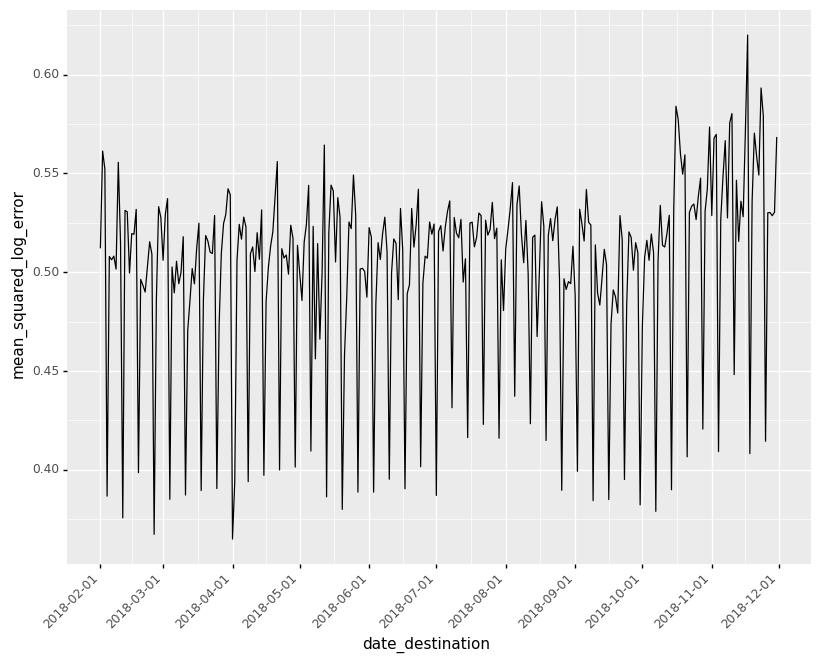


/home/manomano/.pyenv/versions/3.7.0/envs/challenge_datafactory_intermarche/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 9.600000000000001 x 7.199999999999999 in image.
/home/manomano/.pyenv/versions/3.7.0/envs/challenge_datafactory_intermarche/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: data/loss_date_destination_ape.png


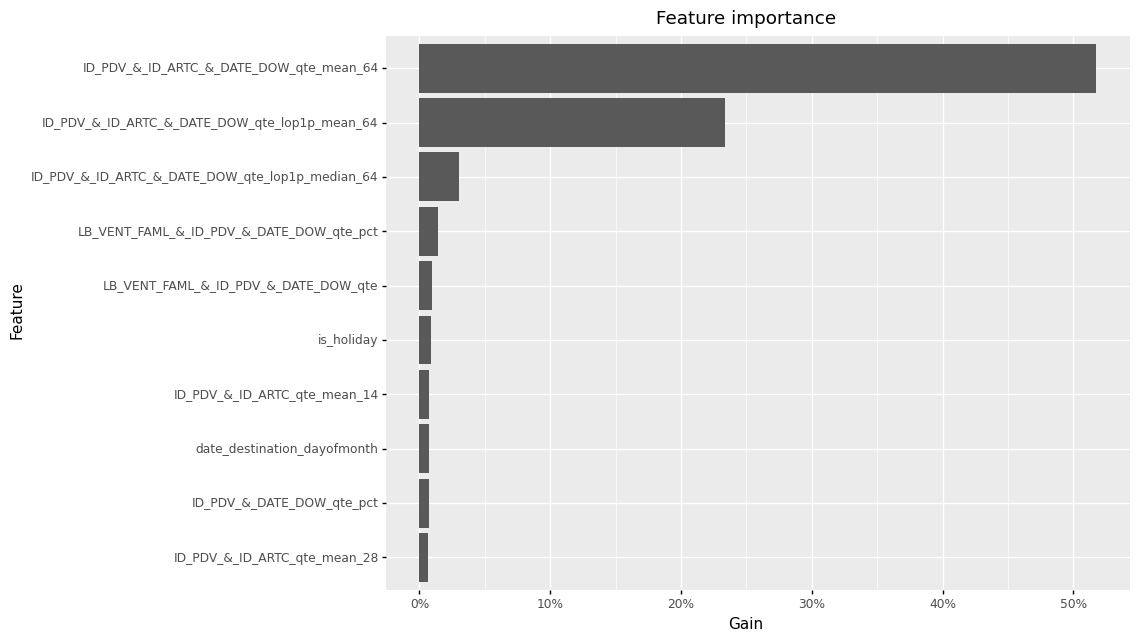


/home/manomano/.pyenv/versions/3.7.0/envs/challenge_datafactory_intermarche/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 9.600000000000001 x 7.199999999999999 in image.
/home/manomano/.pyenv/versions/3.7.0/envs/challenge_datafactory_intermarche/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: data/importance.png


In [31]:
print(train_predict.train.__doc__)
learning = pd.read_parquet(path.path_learning)
learning = learning[learning["evaluated"]]  # See evaluated doc why we do this

MIN_WEEK_HISTORY = 0
learning = learning[
    learning["ID_PDV_&_ID_ARTC_date_origin_MINUS_date_min"] > 7 * MIN_WEEK_HISTORY
]

# Avoid random train_test split due to sample of the line/mergeasof done before
learning = learning.sort_values("date_destination")
train, valid = train_test_split(learning, test_size=0.2, shuffle=False)

target = "qte_lop1p"
to_drop = [
    "date_origin",
    "date_destination",
    "id_pdv",
    "id_artc",
    "pred",
    "qte",
    "ID_PDV_&_ID_ARTC_date_min",
    "evaluated",
    "lb_vent_rayn",
    "lb_vent_faml",
    "lb_vent_sous_faml",
    "date_origin_week",
    "date_destination_week",
]
X_cols = list(learning.drop(columns=to_drop + [target], errors="ignore"))

X_learning = learning[X_cols]
X_train = train[X_cols]
X_valid = valid[X_cols]

y_learning = learning[target]
y_train = train[target]
y_valid = valid[target]

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid)
lgb_learning = lgb.Dataset(X_learning, label=y_learning)

l_params = []
for num_leaves in [31, 63, 127]:
    # num_leaves is the main parameter to control the complexity of the tree model
    # bag 3 times the same model with different params. Helps to stabilize
    # predictions.
    param_tmp = {
        "objective": "regression_l2",
        "metric": "rmse",
        "learning_rate": 0.1,
        "random_state": 1,
        "verbosity": -1,
        "num_leaves": num_leaves,
    }
    l_params.append(param_tmp)

model_lgb = Model_LGB_Bagging(l_params=l_params)
model_lgb.train(lgb_train, lgb_valid)

train["pred"] = model_lgb.predict(X_train)
valid["pred"] = model_lgb.predict(X_valid)

loss_horizon = (
    valid.groupby("horizon")
    .apply(metric_mean_squared_log_error)
    .rename("loss")
    .reset_index()
)
loss_horizon = loss_horizon.sort_values("horizon")
loss_horizon["loss_90"] = (
    loss_horizon["loss"].rolling(90, min_periods=90).mean().shift(-90)
)
loss_horizon = loss_horizon[loss_horizon["loss_90"].notnull()]

loss_horizon = (
    ggplot(loss_horizon, aes("horizon", "loss_90"))
    + pn.geoms.geom_line()
    + pn.labs(
        title="Is using a bigger horizon origin problematic?",
        x="Horizon origin",
        y="Rolling 90 mean_squared_log_error",
    )
    + pn.theme(axis_text_x=pn.element_text(rotation=45, hjust=1))
)

loss_horizon.save("data/loss_horizon.png")

loss_date_destination = pd.concat(
    [
        train.groupby("date_destination")
        .apply(metric_mean_squared_log_error)
        .rename("mean_squared_log_error")
        .reset_index(),
        valid.groupby("date_destination")
        .apply(metric_mean_squared_log_error)
        .rename("mean_squared_log_error")
        .reset_index(),
    ]
)

loss_date_destination = (
    ggplot(loss_date_destination, aes("date_destination", "mean_squared_log_error"))
    + pn.geoms.geom_line()
    + pn.theme(axis_text_x=pn.element_text(rotation=45, hjust=1))
)
loss_date_destination.save("data/loss_date_destination.png")
print(loss_date_destination)

loss_date_destination = pd.concat(
    [
        train.groupby("date_destination")
        .apply(metric_mean_absolute_percentage_error)
        .rename("mean_absolute_percentage_error")
        .reset_index(),
        valid.groupby("date_destination")
        .apply(metric_mean_absolute_percentage_error)
        .rename("mean_absolute_percentage_error")
        .reset_index(),
    ]
)

loss_date_destination["mean_absolute_percentage_error"] = loss_date_destination[
    "mean_absolute_percentage_error"
].clip(0, 0.01)

loss_date_destination = (
    ggplot(
        loss_date_destination,
        aes("date_destination", "mean_absolute_percentage_error"),
    )
    + pn.geoms.geom_line()
    + pn.theme(axis_text_x=pn.element_text(rotation=45, hjust=1))
)
loss_date_destination.save("data/loss_date_destination_ape.png")

train_loss = mean_squared_error(y_train, train["pred"], squared=False)
valid_loss = mean_squared_error(y_valid, valid["pred"], squared=False)

importance = ml_utils.get_importance_lgb(model_lgb.model_lgb[0])
plot_importance = ml_utils.plot_importance_lgb(importance.head(10))
print(plot_importance)
plot_importance.save("data/importance.png")
importance.to_csv("data/importance.csv")

mlflow.set_experiment("train")
with mlflow.start_run():
    mlflow.log_param("ENV", constants.CURRENT_ENVIRONMENT)
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("valid_loss", valid_loss)
    # mlflow.log_metric("best_iteration", model_lgb.best_iteration)
    mlflow.log_artifact("data/importance.png")
    mlflow.log_artifact("data/importance.csv")
    mlflow.log_artifact("data/loss_horizon.png")
    mlflow.log_artifact("data/loss_date_destination.png")
    mlflow.log_artifact("data/loss_date_destination_ape.png")
mlflow.end_run()

if constants.CURRENT_ENVIRONMENT == "prod":
    # Retrain on full data - always useful on timeseries
    model_lgb.update_params()
    l_params = model_lgb.l_params
    model_lgb = Model_LGB_Bagging(l_params=l_params)
    model_lgb.train(lgb_learning, None)

# Dump artefacts
artefacts = (model_lgb, X_cols)
pickle.dump(artefacts, open(path.path_artefacts, "wb"))


# Predict

In [32]:
print(train_predict.predict.__doc__)
(model_lgb, X_cols) = pickle.load(open(path.path_artefacts, "rb"))

for date_origin in constants.RANGE_DATE_ORIGIN_PROD:
    # takes ~5mins for each run. Surprised that it is so slow
    prod = pd.read_parquet(path.path_prod(date_origin))
    X_prod = prod[X_cols]
    prod["pred"] = model_lgb.predict(X_prod)
    prod["pred"] = prod["pred"].clip(0)  # Sometimes lgb predict < 0

    prod.loc[prod["date_destination"] == "2019-01-01", "pred"] = 0

    submission = prod[["id_pdv", "id_artc", "date_destination", "pred"]].rename(
        columns={"pred": "qte"}
    )

    submission.to_parquet(path.path_submission_raw(date_origin))

    submission["qte"] = np.expm1(submission["qte"])  # reverse the log1p
    submission["qte"] = ml_utils.smart_round_to_int(submission["qte"])
    submission = submission[submission["qte"] != 0]
    submission["id"] = utils.format_id(
        submission["id_pdv"],
        submission["id_artc"],
        submission["date_destination"].dt.strftime("%Y%m%d"),
    )
    submission = submission[["id", "qte"]]
    submission.to_csv(
        path.path_submission(date_origin), compression="zip", index=False
    )

Predict prod dataset and create submission file for each date_origin


In [33]:
# Note this small trick 0.002 boost
print(ml_utils._smart_round_to_int.__doc__)

Round smarly to the lower of upper integer in order to minimize rmlse

    Args:
        x_float (float): [description]

    Returns:
        int:
    


# Bagging

In [34]:
print(train_predict.bag_sub_date_origin.__doc__)
subs = []
# The dates to bag.
date_origin_bagg = [datetime.date(2018, 12, 20), datetime.date(2018, 12, 21)]
for date_origin in date_origin_bagg:
    tmp = pd.read_parquet(path.path_submission_raw(date_origin))
    tmp["date_origin"] = date_origin
    subs.append(tmp)

subs = pd.concat(subs)

subs_bagg = subs[subs["date_origin"].isin(date_origin_bagg)]

subs_bagg = (
    subs_bagg.groupby(["id_pdv", "id_artc", "date_destination"])["qte"]
    .mean()
    .reset_index()
)

subs_bagg["qte"] = np.expm1(subs_bagg["qte"])
subs_bagg["qte"] = ml_utils.smart_round_to_int(subs_bagg["qte"])
subs_bagg = subs_bagg[subs_bagg["qte"] != 0]
subs_bagg["id"] = utils.format_id(
    subs_bagg["id_pdv"],
    subs_bagg["id_artc"],
    subs_bagg["date_destination"].dt.strftime("%Y%m%d"),
)
subs_bagg = subs_bagg[["id", "qte"]]
name = "_".join([str(i) for i in date_origin_bagg])
subs_bagg.to_csv(
    path.path_submission(name),
    compression="zip",
    index=False,
)

Bag (average) predictions from different date_origin.
    Provides a small boost.
    


# Final words

Designing a good challenge is hard and takes a lot of time (defining correctly the business problem is harder than solving it ;) ). So I'm thankful to the organizers for the challenge.

Few things could have made the competition more reliable, less magic-tricks prone and more closer to a production set-up :

* Lack of historical data made it extremely hard to have a local validation correlated to the leaderboard. Hence manual/parametric adjustements were required instead of just letting the model infer it with good feature engineering. Providing the aggregated sales by category on the last X previous year wouldn't have made data size much bigger but would have allowed better seasonality handling.
* The absence of a private leaderboard created an incentive to bruteforce and overfit fit.

Happy to discuss about it! See you next year?
 

# Any questions?

Jacques Peeters @LinkedIn

jacques.peeters@manomano.com 

Hiring for various positions (ML engineer, Product Data Scientist, ...) @ManoMano 🦄 https://jobs.lever.co/manomano?department=DATA
